In [1]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [2]:
data = pd.read_csv("epl_22_23.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [3]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.matchId==next_actions.matchId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['matchId' ] = nex.matchId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team_name','playerName','h_a']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['playerName' ]= nex.playerName
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['matchId','period','action_id']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [4]:
data = add_carries(data)

In [20]:
data = data[data['playerId'] == 425319]

In [21]:
data['take_on_won'] = (data['type'] == 'TakeOn') & (data['outcomeType'] == 'Successful')
data['take_on_lost'] = (data['type'] == 'TakeOn') & (data['outcomeType'] == 'Unsuccessful')
data['tackle_won'] = (data['type'] == 'Tackle') & (data['outcomeType'] == 'Successful')
data['tackle_lost'] = (data['type'] == 'Tackle') & (data['outcomeType'] == 'Unsuccessful')
data['interception'] = (data['type'] == 'Interception') & (data['outcomeType'] == 'Successful')
data['ball_won'] = (data['type'] == 'BallRecovery')

C:\Users\91852\AppData\Local\Temp/ipykernel_11604/3220711115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['take_on_won'] = (data['type'] == 'TakeOn') & (data['outcomeType'] == 'Successful')
C:\Users\91852\AppData\Local\Temp/ipykernel_11604/3220711115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['take_on_lost'] = (data['type'] == 'TakeOn') & (data['outcomeType'] == 'Unsuccessful')
C:\Users\91852\AppData\Local\Temp/ipykernel_11604/3220711115.py:3: SettingWithCopyWarning: 
A value is tr

In [22]:
data_passes = data[data['type'] == 'Pass']

In [23]:
data_succ = data_passes[data_passes['outcomeType'] == 'Successful']
data_unsucc = data_passes[data_passes['outcomeType'] == 'Unsuccessful']

data_succ_prog = data_succ.reset_index()
data_unsucc_prog = data_unsucc.reset_index()
data_succ_prog['beginning'] = np.sqrt(np.square(120-data_succ_prog['x']) + np.square(40 - data_succ_prog['y']))
data_succ_prog['end'] = np.sqrt(np.square(120 - data_succ_prog['endX']) + np.square(40 - data_succ_prog['endY']))

data_succ_prog['progressive'] = [(data_succ_prog['end'][x]) / (data_succ_prog['beginning'][x]) < .75 for x in range(len(data_succ_prog.beginning))]
data_succ_prog = data_succ_prog[data_succ_prog['progressive'] == True]

In [24]:
data_carries = data[data['type'] == 'Carry']

data_carries_succ = data_carries[data_carries['outcomeType'] == 'Successful']
data_carries_unsucc = data_carries[data_carries['outcomeType'] == 'Unsuccessful']

data_carries_succ_prog = data_carries_succ.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()

data_carries_succ_prog['beginning'] = np.sqrt(np.square(120-data_carries_succ_prog['x']) + np.square(40 - data_carries_succ_prog['y']))
data_carries_succ_prog['end'] = np.sqrt(np.square(120 - data_carries_succ_prog['endX']) + np.square(40 - data_carries_succ_prog['endY']))

data_carries_succ_prog['progressive'] = [(data_carries_succ_prog['end'][x]) / (data_carries_succ_prog['beginning'][x]) < .75 for x in range(len(data_carries_succ_prog.beginning))]
data_carries_succ_prog = data_carries_succ_prog[data_carries_succ_prog['progressive'] == True]

In [25]:
data_succ_prog = data_succ_prog[data_succ_prog['passCorner'] == False]

In [26]:
left_halfspace_x_min = 18
left_halfspace_x_max = 18 + 42
left_halfspace_y_min = 50
left_halfspace_y_max = 50 + 12
    
    
right_halfspace_x_min = 18
right_halfspace_x_max = 18 + 42
right_halfspace_y_min = 18
right_halfspace_y_max = 18 + 12


In [27]:
# Add 'in_rhs' column to data_succ_prog
data['in_rhs'] = (data['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                       data['y'].between(right_halfspace_y_min, right_halfspace_y_max))

# Add 'in_lhs' column to data_succ_prog
data['in_lhs'] = (data['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                       data['y'].between(left_halfspace_y_min, left_halfspace_y_max))

# Add 'into_rhs' column to data_succ_prog
#data_succ['into_rhs'] = (data_succ['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
 #                        data_succ['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
  #                       (data_succ['in_rhs'] == False))

# Add 'into_lhs' column to data_succ_prog
#data_succ['into_lhs'] = (data_succ['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
 #                        data_succ['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
  #                       (data_succ['in_lhs'] == False))

# Add 'in_rhs' column to data_carries_succ_prog
data_carries['in_rhs'] = (data_carries['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                          data_carries['y'].between(right_halfspace_y_min, right_halfspace_y_max))

# Add 'in_lhs' column to data_carries_succ_prog
data_carries['in_lhs'] = (data_carries['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                          data_carries['y'].between(left_halfspace_y_min, left_halfspace_y_max))

# Add 'into_rhs' column to data_carries_succ_prog
#data_carries['into_rhs'] = (data_carries['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
 #                           data_carries['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
  #                          (data_carries['in_rhs'] == False))

# Add 'into_lhs' column to data_carries_succ_prog
#data_carries['into_lhs'] = (data_carries['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
 #                           data_carries['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
  #                          (data_carries['in_lhs'] == False))


C:\Users\91852\AppData\Local\Temp/ipykernel_11604/1805356564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_rhs'] = (data['x'].between(right_halfspace_x_min, right_halfspace_x_max) &
C:\Users\91852\AppData\Local\Temp/ipykernel_11604/1805356564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_lhs'] = (data['x'].between(left_halfspace_x_min, left_halfspace_x_max) &
C:\Users\91852\AppData\Local\Temp/ipykernel_11604/1805356564.py:20: SettingWithCopyWarning: 
A value is trying to be set

In [28]:
#data_carries_in_rhs = data_carries[data_carries['in_rhs'] == True]
#data_carries_into_rhs = data_carries[data_carries['into_rhs'] == True]
#data_carries_in_lhs = data_carries[data_carries['in_lhs'] == True]
#data_carries_into_lhs = data_carries[data_carries['into_lhs'] == True]


take_on_won_lhs = data[(data['take_on_won'] == True) & (data['in_lhs'] == True)]
take_on_lost_lhs = data[(data['take_on_lost'] == True) & (data['in_lhs'] == True)]
ball_won_lhs = data[(data['type'] == 'BallRecovery') & (data['in_lhs'] == True)]

tackle_won_lhs = data[(data['tackle_won'] == True) & (data['in_lhs'] == True)]
tackle_lost_lhs = data[(data['tackle_lost'] == True) & (data['in_lhs'] == True)]
interception_lhs = data[(data['type'] == 'Interception') & (data['in_lhs'] == True)]


take_on_won_rhs = data[(data['take_on_won'] == True) & (data['in_rhs'] == True)]
take_on_lost_rhs = data[(data['take_on_lost'] == True) & (data['in_rhs'] == True)]
ball_won_rhs = data[(data['type'] == 'BallRecovery') & (data['in_rhs'] == True)]

tackle_won_rhs = data[(data['tackle_won'] == True) & (data['in_rhs'] == True)]
tackle_lost_rhs = data[(data['tackle_lost'] == True) & (data['in_rhs'] == True)]
interception_rhs = data[(data['type'] == 'Interception') & (data['in_rhs'] == True)]


In [29]:
TO_won_lhs = take_on_won_lhs['x'].count()
TO_lost_lhs = take_on_lost_lhs['x'].count()
recovery_lhs = ball_won_lhs['x'].count()
TK_won_lhs = tackle_won_lhs['x'].count()
TK_lost_lhs = tackle_lost_lhs['x'].count()
int_lhs = interception_lhs['x'].count()

TO_won_rhs = take_on_won_rhs['x'].count()
TO_lost_rhs = take_on_lost_rhs['x'].count()
recovery_rhs = ball_won_rhs['x'].count()
TK_won_rhs = tackle_won_rhs['x'].count()
TK_lost_rhs = tackle_lost_rhs['x'].count()
int_rhs = interception_rhs['x'].count()

In [30]:
TK_won_lhs

6

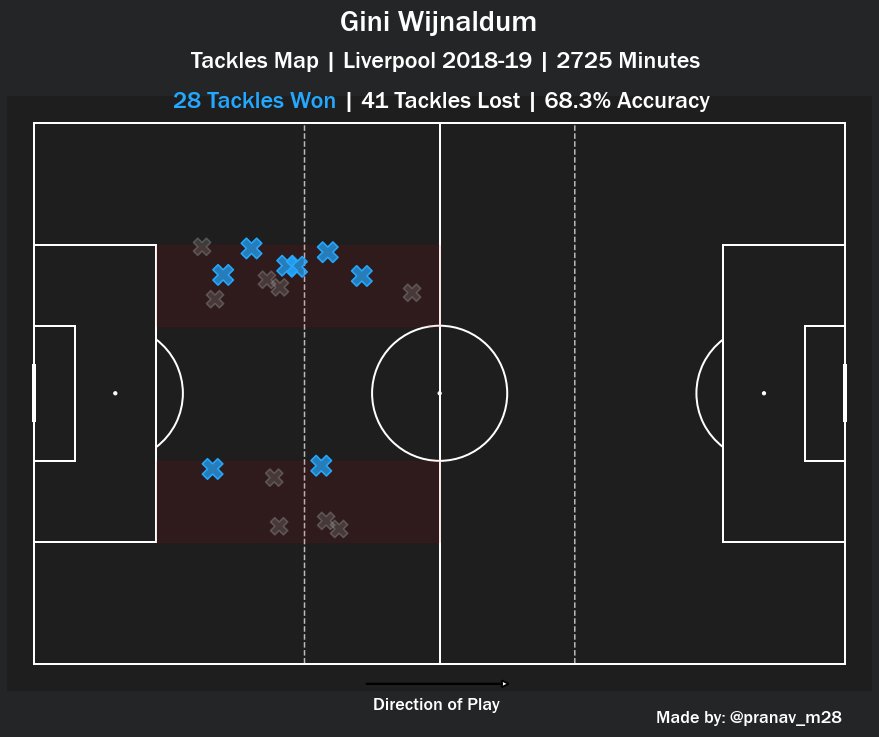

In [31]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)


#Plotting Tackles Won LHS

pitch.scatter(tackle_won_lhs.x, tackle_won_lhs.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(tackle_won_lhs.x, tackle_won_lhs.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting Tackles Lost LHS

pitch.scatter(tackle_lost_lhs.x, tackle_lost_lhs.y, s=300,
              marker='X', edgecolors='#949494', c='none', zorder=3, ax=ax , alpha=0.4 , ls='-' , lw=1.6)

pitch.scatter(tackle_lost_lhs.x, tackle_lost_lhs.y, s=300,
              marker='X', edgecolors='none', c='#949494', zorder=3, ax=ax , alpha=0.25)

#Plotting Tackles Won RHS

pitch.scatter(tackle_won_rhs.x, tackle_won_rhs.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(tackle_won_rhs.x, tackle_won_rhs.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting Tackles Lost RHS

pitch.scatter(tackle_lost_rhs.x, tackle_lost_rhs.y, s=300,
              marker='X', edgecolors='#949494', c='none', zorder=3, ax=ax , alpha=0.4 , ls='-' , lw=1.6)

pitch.scatter(tackle_lost_rhs.x, tackle_lost_rhs.y, s=300,
              marker='X', edgecolors='none', c='#949494', zorder=3, ax=ax , alpha=0.25)






plt.gca().invert_yaxis()

# Highlight Def. Right Half-Space
right_halfspace_rectangle = plt.Rectangle((18, 18), 42, 12, color='red', alpha=0.08)
ax.add_patch(right_halfspace_rectangle)


# Highlight Def. Left Half-Space
left_halfspace_rectangle = plt.Rectangle((18, 50), 42, 12, color='red', alpha=0.08)
ax.add_patch(left_halfspace_rectangle)


fig_text(
    0.512, 0.945, "<Gini Wijnaldum>", font='Franklin Gothic Medium' , size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Tackles Map | Liverpool 2018-19 | 2725 Minutes",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)




fig_text(
    0.514, 0.851,
    "<28 Tackles Won> | 41 Tackles Lost | 68.3% Accuracy",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color" : "#24a8ff"}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)   


#plt.savefig("Gini 18-19 Tackling.png" , dpi=300, bbox_inches='tight')

In [32]:
#carries_out_lhs = data_carries_into_lhs['x'].count()
#carries_out_rhs = data_carries_into_rhs['x'].count()
#total_carr_in = carries_out_lhs + carries_out_rhs

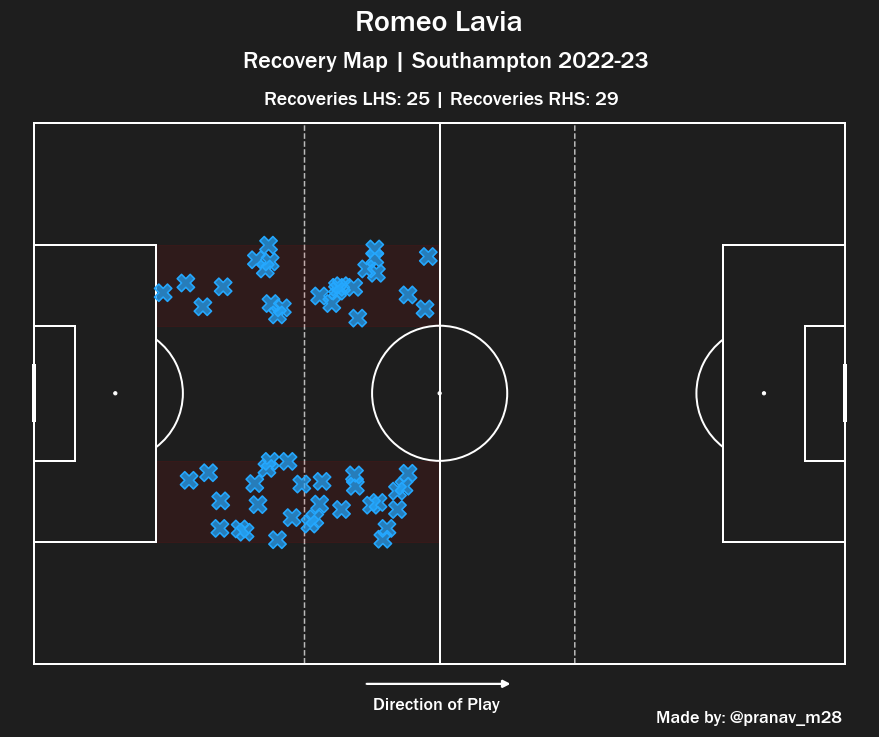

In [39]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#1e1e1e')
ax.patch.set_facecolor('#1e1e1e')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True , line_zorder=2)

pitch.draw(ax=ax)

#bin_statistic = pitch.bin_statistic(recov.x, recov.y, statistic='count', bins=(25, 25))
#bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
#pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#000000' , alpha=0.88)

#Plotting LHS Recoveries

pitch.scatter(ball_won_lhs.x, ball_won_lhs.y, s=300,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(ball_won_lhs.x, ball_won_lhs.y, s=300,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting RHS Recoveries

pitch.scatter(ball_won_rhs.x, ball_won_rhs.y, s=300,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(ball_won_rhs.x, ball_won_rhs.y, s=300,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)




plt.gca().invert_yaxis()

# Highlight Def. Right Half-Space
right_halfspace_rectangle = plt.Rectangle((18, 18), 42, 12, color='red', alpha=0.08)
ax.add_patch(right_halfspace_rectangle)


# Highlight Def. Left Half-Space
left_halfspace_rectangle = plt.Rectangle((18, 50), 42, 12, color='red', alpha=0.08)
ax.add_patch(left_halfspace_rectangle)


fig_text(
    0.512, 0.945, "<Romeo Lavia>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Recovery Map | Southampton 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.514, 0.851,
    f"Recoveries LHS: {recovery_lhs} | Recoveries RHS: {recovery_rhs}",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.514, 0.851,
    "<>",
    size=13,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)  

#plt.savefig('Lavia Recoveries Half Spaces.png' , dpi=300 , bbox_inches='tight')

In [176]:
passes_inside_lhs = data_succ_pass_in_lhs['x'].count()
passes_inside_rhs = data_succ_pass_in_rhs['x'].count()
total_pass_inside = passes_inside_lhs + passes_inside_rhs

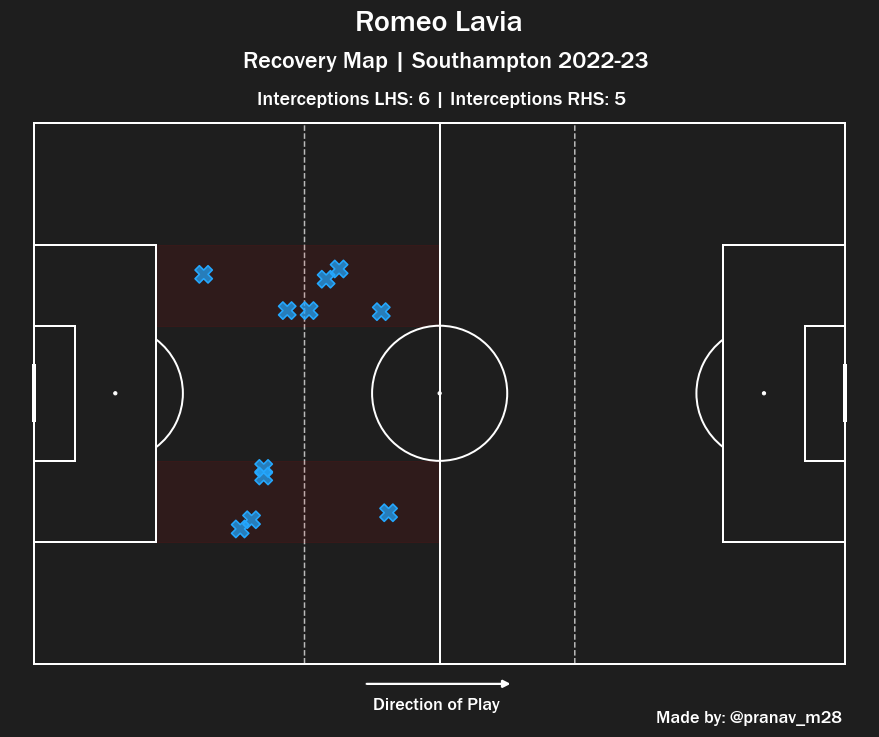

In [40]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#1e1e1e')
ax.patch.set_facecolor('#1e1e1e')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True , line_zorder=2)

pitch.draw(ax=ax)

#bin_statistic = pitch.bin_statistic(recov.x, recov.y, statistic='count', bins=(25, 25))
#bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
#pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#000000' , alpha=0.88)

#Plotting LHS Recoveries

pitch.scatter(interception_lhs.x, interception_lhs.y, s=300,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(interception_lhs.x, interception_lhs.y, s=300,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting RHS Recoveries

pitch.scatter(interception_rhs.x, interception_rhs.y, s=300,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(interception_rhs.x, interception_rhs.y, s=300,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)




plt.gca().invert_yaxis()

# Highlight Def. Right Half-Space
right_halfspace_rectangle = plt.Rectangle((18, 18), 42, 12, color='red', alpha=0.08)
ax.add_patch(right_halfspace_rectangle)


# Highlight Def. Left Half-Space
left_halfspace_rectangle = plt.Rectangle((18, 50), 42, 12, color='red', alpha=0.08)
ax.add_patch(left_halfspace_rectangle)


fig_text(
    0.512, 0.945, "<Romeo Lavia>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Recovery Map | Southampton 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.514, 0.851,
    f"Interceptions LHS: {int_lhs} | Interceptions RHS: {int_rhs}",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.514, 0.851,
    "<>",
    size=13,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)  

#plt.savefig('Lavia Recoveries Half Spaces.png' , dpi=300 , bbox_inches='tight')